In [1]:
import librosa
import numpy as np
import scipy.signal as signal
from pydub import AudioSegment
from IPython.display import Audio
import matplotlib.pyplot as plt
import noisereduce as nr
import pytsmod

/Users/yeon0815/연구/노인 맞춤형 음성 변환/venv/lib/python3.11/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
/Users/yeon0815/연구/노인 맞춤형 음성 변환/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# PCM 파일 읽기

file_path = '/Users/yeon0815/연구/노인 맞춤형 음성 변환/한국어 음성/한국어_음성_분야/KsponSpeech_01/KsponSpeech_0004/KsponSpeech_003001.pcm'

with open(file_path, 'rb') as pcmfile:
    pcm_data = np.frombuffer(pcmfile.read(), dtype=np.int16)
    pcm_data = pcm_data.astype(np.float32) / np.iinfo(np.int16).max
    y = librosa.resample(pcm_data, orig_sr=22050, target_sr=22050)

Audio(y, rate=22050)

In [3]:
pcm_data.shape

(123456,)

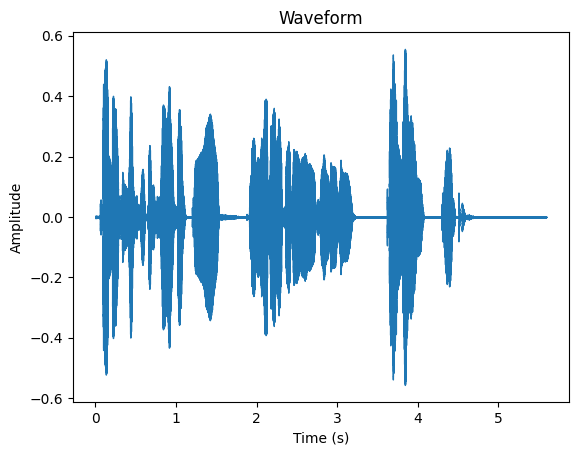

In [4]:
librosa.display.waveshow(y, sr=22050)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

In [5]:
X = librosa.stft(y)
X_db = librosa.amplitude_to_db(abs(X))

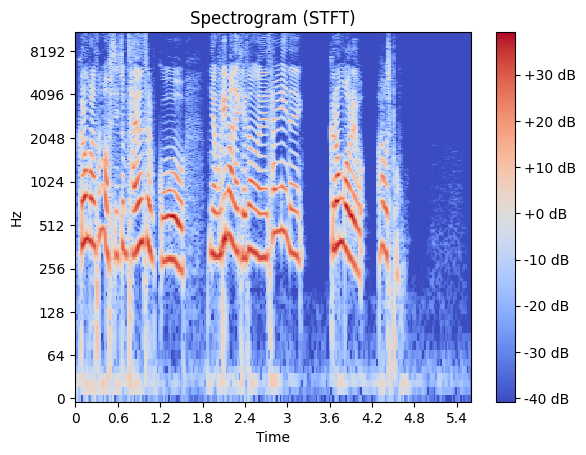

In [6]:
librosa.display.specshow(X_db, sr=22050, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (STFT)')
plt.show()

In [13]:
# sos = signal.butter(10, 6000, 'hp', fs=22050, output='sos')
# high_freq = signal.sosfilt(sos, y)
# print(high_freq.shape)
# Audio(high_freq, rate=22050)

In [8]:
# high_freq_shifted = librosa.effects.pitch_shift(y=high_freq, sr=22050, n_steps=-3)
# Audio(high_freq_shifted, rate=22050)

In [24]:
sos_lp = signal.butter(10, 6000, 'lp', fs=22050, output='sos')
low_freq = signal.sosfilt(sos_lp, y)
Audio(low_freq, rate=22050)

In [25]:
sos = signal.butter(10, 200, 'hp', fs=22050, output='sos')
high_freq = signal.sosfilt(sos, low_freq)
print(high_freq.shape)
Audio(high_freq, rate=22050)

(123456,)


In [28]:
# def smooth_eq(data, sr):
#     # 저주파 강화 (300Hz 이하)
#     b_low, a_low = signal.butter(4, 300 / (0.5 * sr), btype='low')
#     filtered_low = signal.lfilter(b_low, a_low, data)
    
#     # 고주파 감쇠 (3000Hz 이상)
#     b_high, a_high = signal.butter(4, 3000 / (0.5 * sr), btype='high')
#     filtered_high = signal.lfilter(b_high, a_high, filtered_low)

#     return filtered_high


# # Apply smooth EQ
# data_eq = smooth_eq(low_freq, 22050)
# Audio(data_eq, rate=22050)

In [11]:
# combined = low_freq + high_freq_shifted
# Audio(combined, rate=22050)

In [52]:
# pitch shift 방법 / 울림이 강함
y_shifted = librosa.effects.pitch_shift(y=y, sr=22050, n_steps=-5)
Audio(y_shifted, rate=22050)

In [45]:
# phase vocoder 이용한 울림 최소화한 pitch shift
rate = 0.6

D = librosa.stft(y)
y_shifted = librosa.istft(librosa.phase_vocoder(D, rate=rate))
Audio(y_shifted, rate=22050)

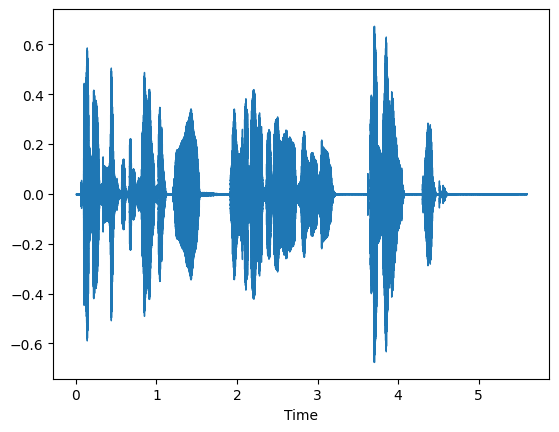

In [29]:
librosa.display.waveshow(y=high_freq, sr=22050)

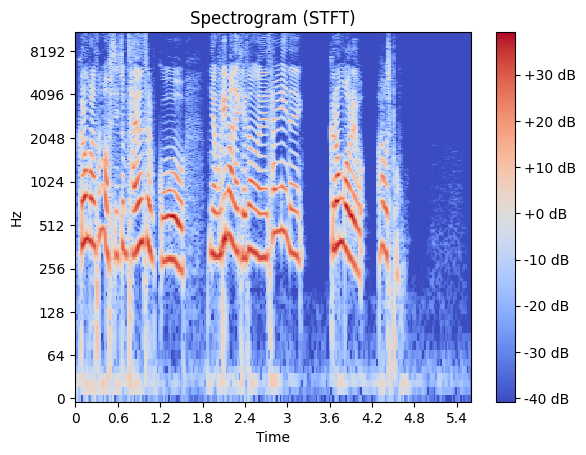

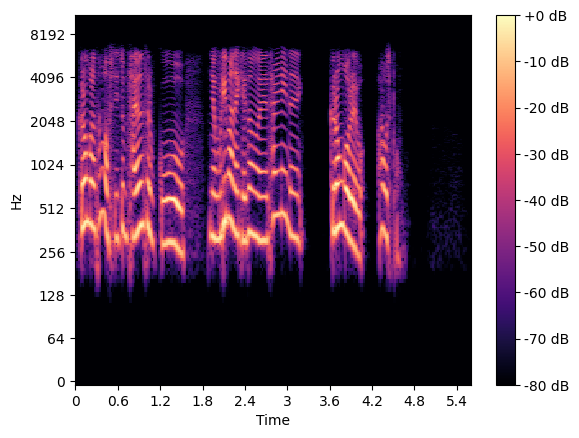

In [30]:
librosa.display.specshow(X_db, sr=22050, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (STFT)')
plt.show()

# 고주파수 변환 후 스펙트로그램

D = np.abs(librosa.stft(high_freq))
D_db = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(D_db, sr=22050, y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [32]:
# 노이즈 감소 필터 2

shift_denoised = nr.reduce_noise(y=high_freq, sr=22050)
Audio(shift_denoised, rate=22050)

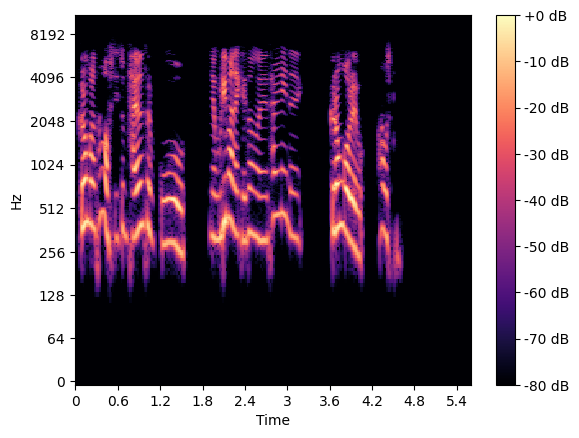

In [33]:
# 노이즈 제거 후 스펙트로그램

D_deno = np.abs(librosa.stft(shift_denoised))
D_db_deno = librosa.amplitude_to_db(D_deno, ref=np.max)
librosa.display.specshow(D_db_deno, sr=22050, y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [ ]:
# signal_to_noise_level 비교해보기




In [15]:
# # 노이즈 제거 1 / 오히려 노이즈 생김
# noise_factor = 0.005
# freq_denoised = freq_shifted - noise_factor * np.random.normal(0, 1, len(freq_shifted))

In [34]:
# 리버브 효과 추가
import pyroomacoustics as pra

# Apply reverb
room = pra.ShoeBox([10, 7, 3], fs=22050, max_order=2, absorption=0.2)
room.add_source([2, 2, 1.5], signal=shift_denoised)
room.add_microphone([6, 4, 1.5])
room.simulate()
reverbed_audio = room.mic_array.signals[0]
Audio(reverbed_audio, rate=22050)

In [ ]:
D_reverb = np.abs(librosa.stft(reverbed_audio))
D_db_deno = librosa.amplitude_to_db(D_deno, ref=np.max)
librosa.display.specshow(D_db_deno, sr=22050, y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.show()